# Challenge

In [160]:
import numpy as np
import pandas as pd
import os
import sklearn
import csv
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import Normalizer


In [161]:
feature_label_df = pd.read_csv('feature_label.csv')
feature_engineered_df = pd.read_csv('feature_engineered_df.csv')
label_meta_df = pd.read_csv('train_meta.csv')


In [167]:
def rename_columns(df, word):
    new_columns = (df.columns[1:] + word)
    new_columns =  new_columns.insert(0, df.columns[0])
    print(new_columns)
    df.columns = new_columns
    return df

def get_fourier_transform(y): 
    fourier_transform = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d = 1)
    positive_frequencies_indexes = frequencies >= 0
    positive_frequencies = frequencies[positive_frequencies_indexes]
    positive_frequencies_fourier_transform = np.abs(fourier_transform[positive_frequencies_indexes])
    df = pd.DataFrame(positive_frequencies).rename({0: 'frequency'}, axis = 1)
    df.loc[:, 'fourier transform'] = positive_frequencies_fourier_transform
    return df

def get_phase_using_fourier(y): 
    fourier_transform = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(y), d = 1)
    max_amp_index = np.argmax(np.abs(fourier_transform))
    frequency = frequencies[max_amp_index]
    phase_shift = np.angle(fourier_transform[max_amp_index])
    return phase_shift, frequency

def get_random_sample(df): 
    measurement_id = np.random.choice(feature_label_df.loc[:, 'measurement id'].unique())
    filt_df = df[df.loc[:, 'measurement id'] == measurement_id]
    return filt_df
    
def get_representative_label_df(df): 
    measurement_id = label_meta_df.groupby('label', as_index = False).first().loc[:, 'measurement id']
    representative_label_df = df[df.loc[:, 'measurement id'].isin(measurement_id)]
    return representative_label_df

def get_measurements_from_label(df, label, num_measurements): 
    # measurement_id = label_meta_df.groupby('label', as_index = False).first().loc[:, 'measurement id']
    measurement_ids = df[df.loc[:, 'label'] == label].loc[:,'measurement id'].unique()
    comp_measurement_ids = measurement_ids[0:num_measurements]
    measurements_from_label = df[df.loc[:, 'measurement id'].isin(comp_measurement_ids)]
    return measurements_from_label

def plot_learning_curve(sizes,train,val):
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    axes.legend(loc="best")
    
    plt.show()
    return

## importing the data

In [163]:
train_filepath = r'/kyukon/home/gent/460/vsc46035/machine learning/challenge/misalignment-detection/misalignment-detection/train'
test_filepath = r'/kyukon/home/gent/460/vsc46035/machine learning/challenge/misalignment-detection/misalignment-detection/test'

## features

### import features

In [11]:
feature_filename = os.listdir(train_filepath)[0]
feature_df = pd.read_csv(train_filepath + '/' + feature_filename).rename({'Unnamed: 0': 'index'}, axis = 1)
feature_df.columns = ['time_index','h_res', 'l_res', 'acc']
feature_df.head()

,time_index,h_res,l_res,acc
0,0,0.011631,0.110440,-0.000326
1,1,0.010736,0.103470,-0.000259
2,2,0.010152,0.096711,-0.000214
3,3,0.009542,0.089917,-0.000211
4,4,0.008621,0.083221,-0.000177


We can concatenate all our features into one df

In [15]:
df_array = []
id_array = np.arange(0, 1100, 1)
for id in id_array:
    test_filename = 'train_'+ str(id) + '.csv'
    df = pd.read_csv(train_filepath + '/' + test_filename).rename({'Unnamed: 0': 'index'}, axis = 1)
    df.columns = ['time_index','h_res', 'l_res', 'acc']
    df.loc[:, 'measurement id'] = [id]*df.shape[0]
    df_array += [df]

In [16]:
concat_feature_df = pd.concat(df_array).reset_index(drop = True)
concat_feature_df.tail()

,time_index,h_res,l_res,acc,measurement id
2199995,1995,-0.030043,-0.27426,-0.000058,1099
2199996,1996,-0.030163,-0.27438,-0.000140,1099
2199997,1997,-0.030298,-0.27451,-0.000162,1099
2199998,1998,-0.030268,-0.27448,-0.000114,1099
2199999,1999,-0.030144,-0.27420,-0.000147,1099


In [17]:
concat_feature_df.to_csv('concat_features.csv', index = False)

### data analysis on features

Are there any Nan's in the dataframe

In [7]:
concat_feature_df = pd.read_csv('concat_features.csv')

In [8]:
print(concat_feature_df.describe())
print(' ')
print(concat_feature_df.info())

         time_index         h_res         l_res           acc  measurement id
count  2.200000e+06  2.200000e+06  2.200000e+06  2.200000e+06    2.200000e+06
mean   9.995000e+02 -8.851904e-04 -1.171427e-04 -1.485804e-04    5.495000e+02
std    5.773503e+02  2.019881e-02  1.949189e-01  1.502693e-04    3.175426e+02
min    0.000000e+00 -3.161600e-02 -2.875300e-01 -1.688300e-03    0.000000e+00
25%    4.997500e+02 -2.137700e-02 -2.007900e-01 -2.405600e-04    2.747500e+02
50%    9.995000e+02 -8.768300e-04 -3.950850e-05 -1.622000e-04    5.495000e+02
75%    1.499250e+03  1.961600e-02  2.006600e-01 -6.891200e-05    8.242500e+02
max    1.999000e+03  2.976100e-02  2.852900e-01  1.188600e-03    1.099000e+03
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200000 entries, 0 to 2199999
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time_index      int64  
 1   h_res           float64
 2   l_res           float64
 3   acc             float64
 4   measu

/tmp/ipykernel_2917620/4055352799.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1) #plot h_res


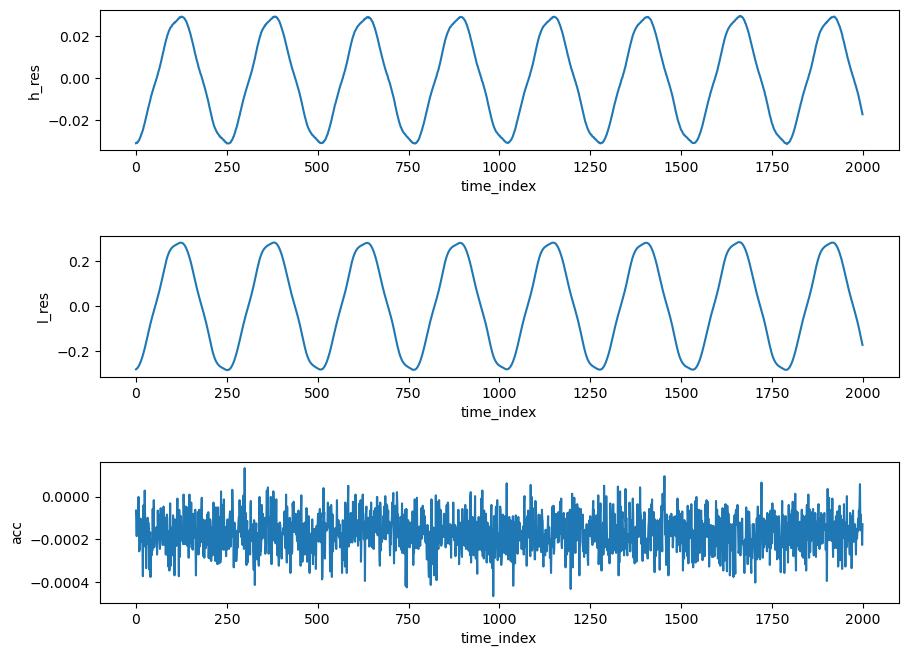

In [9]:
%matplotlib inline
#let's take one of the measurements
df = concat_feature_df[concat_feature_df.loc[:, 'measurement id'] == 100]
plt.subplot(3, 1, 1) #plot h_res
sns.lineplot(data = df, x = 'time_index',  y= 'h_res')
plt.subplot(3, 1, 2) #plot l_res
sns.lineplot(data = df, x = 'time_index',  y= 'l_res')
plt.subplot(3, 1, 3) #plot acc
sns.lineplot(data = df, x = 'time_index',  y= 'acc')

plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.show()

In total, there are 1100 time series, which we probably need to characterize. The files are called train_301.csv, train_311.csv etc.

## import labels and metadata

In [13]:
#we take a look at the train_meta.csv file
label_meta_df = pd.read_csv('train_meta.csv')
label_meta_df =  label_meta_df.rename({'id': 'measurement id'}, axis = 1)

In [14]:
label_meta_df

,measurement id,direction,group,label,speed
0,0,V,DAQ_8,-0.2,425
1,1,H,DAQ_1,0.0,750
2,2,V,DAQ_1,0.0,425
3,3,V,DAQ_9,-0.3,750
4,4,H,DAQ_9,-0.3,750
...,...,...,...,...,...
1095,1095,V,DAQ_1,0.0,425
1096,1096,H,DAQ_10,-0.4,425
1097,1097,H,DAQ_1,0.0,750
1098,1098,V,DAQ_6,0.5,425


/tmp/ipykernel_79103/4124149367.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(np.arange(1,12,1), rotation =45)


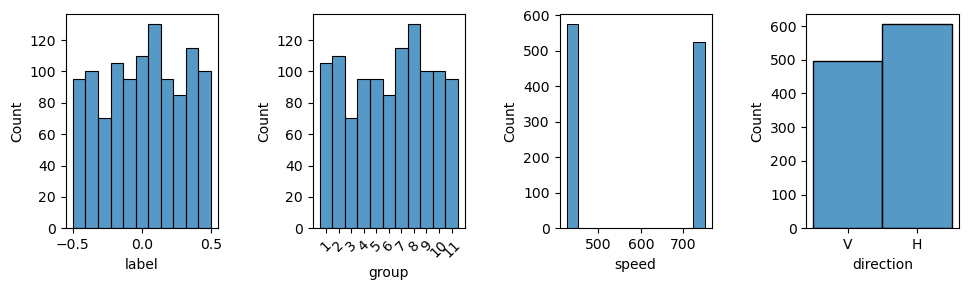

In [15]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols= 4, figsize=(8, 3))

sns.histplot(data = label_meta_df.loc[:, 'label'], ax = axes[0], bins = 11)
sns.histplot(data = label_meta_df.loc[:, 'group'], ax = axes[1])
axes[1].set_xticklabels(np.arange(1,12,1), rotation =45)
sns.histplot(data = label_meta_df.loc[:, 'speed'], ax = axes[2])
sns.histplot(data = label_meta_df.loc[:, 'direction'], ax = axes[3])
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 3)
plt.show()

The groups are distributed uniformily, so stratifiedgroupkfold will probably not be needed. 

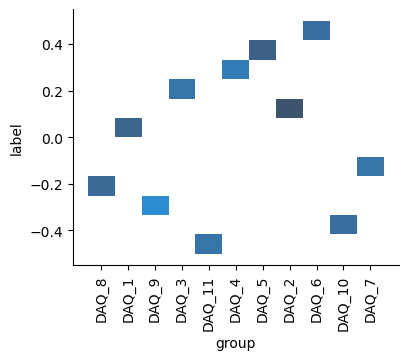

In [30]:
sns.displot(label_meta_df, x ='group', y='label')
plt.xticks(rotation = 90)
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.show()

Here, we can see that the label depends on the DAQ device. Does the speed or the direction depend on the DAC device? -> NO

## features + labels

In [31]:
concat_feature_df = pd.read_csv('concat_features.csv')

We can merge the datasets on their id

In [32]:
label_meta_df, concat_feature_df

(      measurement id direction   group  label  speed
 0                  0         V   DAQ_8   -0.2    425
 1                  1         H   DAQ_1    0.0    750
 2                  2         V   DAQ_1    0.0    425
 3                  3         V   DAQ_9   -0.3    750
 4                  4         H   DAQ_9   -0.3    750
 ...              ...       ...     ...    ...    ...
 1095            1095         V   DAQ_1    0.0    425
 1096            1096         H  DAQ_10   -0.4    425
 1097            1097         H   DAQ_1    0.0    750
 1098            1098         V   DAQ_6    0.5    425
 1099            1099         V   DAQ_6    0.5    750
 
 [1100 rows x 5 columns],
          time_index     h_res    l_res       acc  measurement id
 0                 0 -0.027045 -0.24203 -0.000345               0
 1                 1 -0.026528 -0.23747 -0.000084               0
 2                 2 -0.026161 -0.23259 -0.000192               0
 3                 3 -0.025600 -0.22748 -0.000297           

In [33]:
#
feature_label_df = pd.merge(concat_feature_df, label_meta_df, how = 'left')
feature_label_df.to_csv('feature_label.csv', index = False) #save this file

### is the autocorrelation function label dependent?

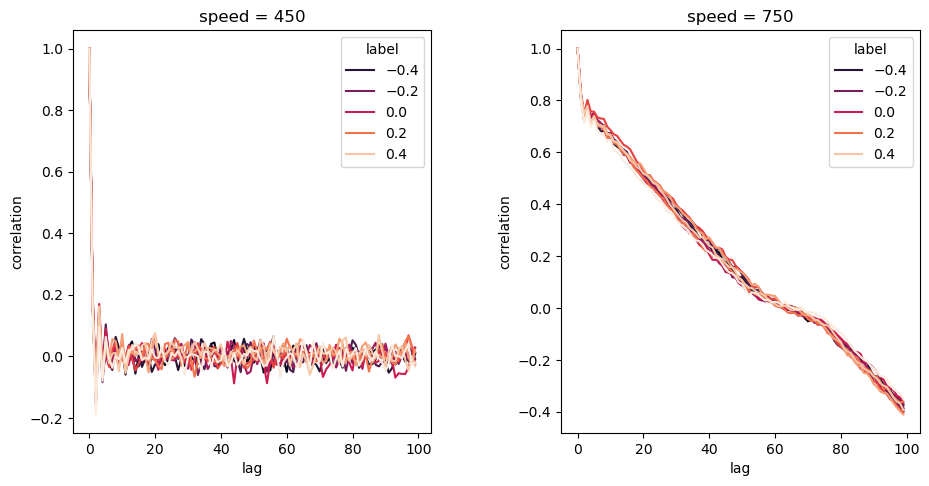

In [35]:
%matplotlib inline
feature_label_df = pd.read_csv('feature_label.csv')
auto_corr_differentiator = 'speed'
auto_corr_differentiator2 = 'label'
#randomly sample from each group
measurement_with_other_labels = feature_label_df.groupby(['label', 'speed'], as_index = False).last().loc[:, 'measurement id']
other_labels_and_speed_df = feature_label_df[feature_label_df.loc[:, 'measurement id'].isin(measurement_with_other_labels)]

def calculate_autocorrelation(group, lag):
    return group['acc'].autocorr(lag = lag)
lag_array = np.arange(0,100,1)
df_array = []
for lag in lag_array: 
    df = other_labels_and_speed_df.groupby([auto_corr_differentiator,auto_corr_differentiator2], as_index = False).apply(calculate_autocorrelation, lag = lag).set_index([auto_corr_differentiator,auto_corr_differentiator2]).reset_index().rename({None: lag}, axis = 1)
    df = pd.melt(df, id_vars = ['speed', 'label'], var_name='lag', value_name = 'acc')
    df_array += [df]
autocorr_df = pd.concat(df_array)

plt.subplot(1,2,1)
sns.lineplot(data = autocorr_df[autocorr_df.loc[:, 'speed'] == 425], x = 'lag',hue = 'label', y= 'acc',palette='rocket')
plt.title('speed = 450')
plt.ylabel('correlation')
plt.subplot(1,2,2)
sns.lineplot(data = autocorr_df[autocorr_df.loc[:, 'speed'] == 750], x = 'lag',hue = 'label', y= 'acc',palette='rocket')
plt.title('speed = 750')
plt.ylabel('correlation')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Conclusion: no it is NOT label dependent, but it depends on the speed. 

### what is the difference of Lres and Hres within the same label?

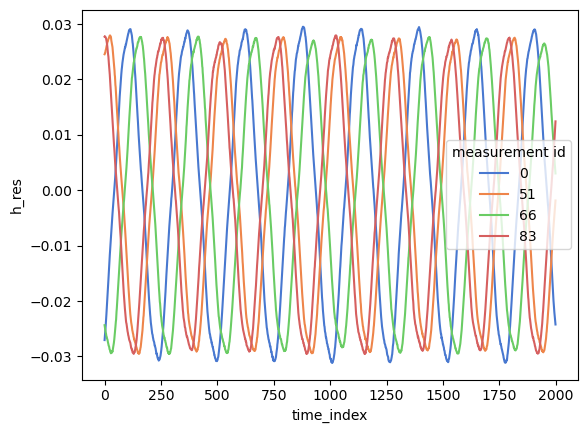

In [48]:
#filter on just on label
measurement_ids = [0,   51,   66,   83]
filt = (feature_label_df.loc[:, 'label'] == -0.2) & (feature_label_df.loc[:, 'measurement id'].isin(measurement_ids))
lbl_df = feature_label_df[filt]

lbl_df
sns.lineplot(data = lbl_df, x = 'time_index', y = 'h_res', hue = 'measurement id', palette = 'muted')
plt.show()

They are all just randomly shifted towards each other. This might not be useful, because there is no information in at what time a certain measurement has started. 

### Is there a difference in the fourier transform of different labels?

In [96]:
feature_label_df.groupby(['label', 'measurement id'], as_index = False)

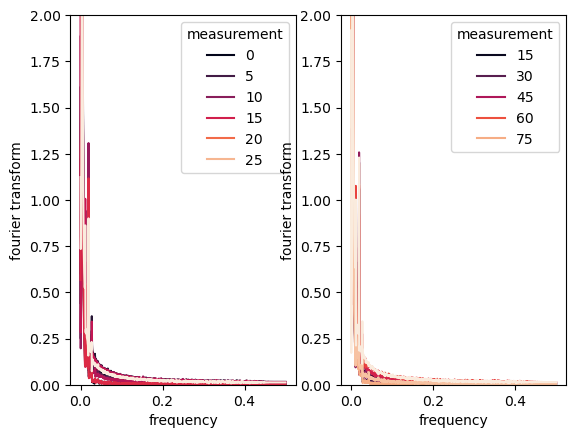

In [191]:
df = get_representative_label_df(feature_label_df)
fourier_df_array = []
for measurement_id in df.loc[:, 'measurement id'].unique(): 
    filt_df = df[df.loc[:, 'measurement id'] == measurement_id]
    fourier_df = get_fourier_transform(filt_df.loc[:, 'h_res'])
    fourier_df.loc[:, 'measurement'] = [measurement_id]*fourier_df.shape[0]
    fourier_df_array += [fourier_df]

concat_fourier_df= pd.concat(fourier_df_array)    
plt.subplot(1,2,1)
sns.lineplot(data = concat_fourier_df, x = 'frequency', y = 'fourier transform', hue = 'measurement', palette = 'rocket')
#plt.xlim(00.01, 0.2)
plt.ylim(0,2)

df = get_measurements_from_label(feature_label_df, 0.1,10)
fourier_df_array = []
for measurement_id in df.loc[:, 'measurement id'].unique(): 
    filt_df = df[df.loc[:, 'measurement id'] == measurement_id]
    fourier_df = get_fourier_transform(filt_df.loc[:, 'h_res'])
    fourier_df.loc[:, 'measurement'] = [measurement_id]*fourier_df.shape[0]
    fourier_df_array += [fourier_df]
    
concat_fourier_df= pd.concat(fourier_df_array)    
plt.subplot(1,2,2)

sns.lineplot(data = concat_fourier_df, x = 'frequency', y = 'fourier transform', hue = 'measurement', palette = 'rocket')
#plt.xlim(00.01, 0.2)
plt.ylim(0,2)
plt.show()

one the left, the Fourier transform of different labels. On the right, the fourier transform of a subset of the same labels. It will be hard to distinguish based on the fourier transform. 

### What is the phase shift of each signal?

-0.25515658064828417 0.004


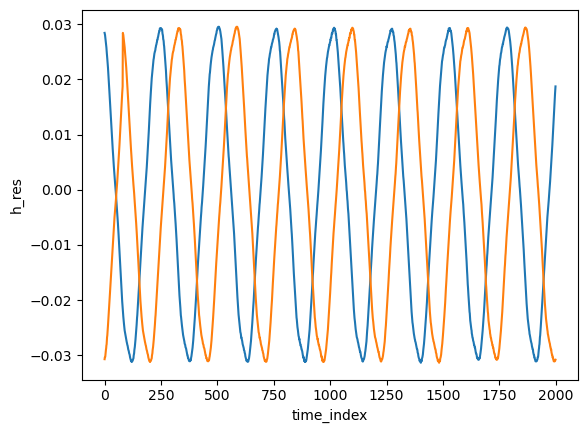

In [307]:
df = get_random_smaple(feature_label_df)
phase_shift, frequency = get_phase_using_fourier(df.loc[:, 'h_res'])
desired_phase_shift = np.pi-phase_shift
print(phase_shift, frequency)
sns.lineplot(data = df, x = 'time_index', y = 'h_res')
plt.plot(df.loc[:, 'time_index'],np.roll(df.loc[:, 'h_res'], -int(phase_shift*len(df.loc[:, 'h_res'])/(2*np.pi))))

## feature engineering

### classical features

In [340]:
#calculate the mean of everything
gr_df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].mean() #x = mean values of each column
gr_df = rename_columns(gr_df, '_mean')
#calculate the standard deviation
df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].std()
df = rename_columns(df, '_std')
gr_df = pd.merge(gr_df,df , on = 'measurement id', how = 'left') #equals to the standard deviation of each column
#calculate the min
df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].min()
df = rename_columns(df, '_min')
gr_df = pd.merge(gr_df,df , on = 'measurement id', how = 'left') #equals to the minimum of each column
#calculate the max 
df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].max()
df = rename_columns(df, '_max')
gr_df = pd.merge(gr_df,df , on = 'measurement id', how = 'left') #equals to the maximum of each column
# gr_df = pd.merge(gr_df, feature_label_df.groupby(['measurement'], as_index = False)['h_res', 'l_res', 'acc'].min(), on = 'measurement', how = 'left') #equals to the min of each measurement column
# gr_df = pd.merge(gr_df, feature_label_df.groupby(['measurement'], as_index = False)['h_res', 'l_res', 'acc'].max(), on = 'measurement', how = 'left') #equals to the min of each measurement column
feature_engineered_df = gr_df
feature_engineered_df.to_csv('feature_engineered_df.csv', index = False)

/tmp/ipykernel_28842/1371939822.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gr_df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].mean() #x = mean values of each column
/tmp/ipykernel_28842/1371939822.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].std()
/tmp/ipykernel_28842/1371939822.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = feature_label_df.groupby(['measurement id'], as_index = False)['h_res', 'l_res', 'acc'].min()
/tmp/ipykernel_28842/1371939822.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = f

Index(['measurement id', 'h_res_mean', 'l_res_mean', 'acc_mean'], dtype='object')
Index(['measurement id', 'h_res_std', 'l_res_std', 'acc_std'], dtype='object')
Index(['measurement id', 'h_res_min', 'l_res_min', 'acc_min'], dtype='object')
Index(['measurement id', 'h_res_max', 'l_res_max', 'acc_max'], dtype='object')


### histogram features

In [146]:
concat_feature_df = pd.read_csv('concat_features.csv')

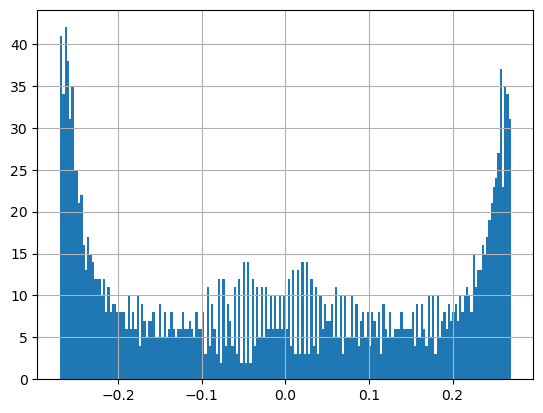

In [147]:
get_random_sample(concat_feature_df).loc[:, 'l_res'].hist(bins = 200)
plt.show()

In [166]:
def get_histogram_results(column_for_histogram, num_bins):
    score_array = []
    measurement_ids = concat_feature_df.loc[:, 'measurement id'].unique()
    vector = []
    for measurement_id in measurement_ids: 
        df = concat_feature_df[concat_feature_df.loc[:,'measurement id'] == measurement_id]
        values, bins = np.histogram(df.loc[:, column_for_histogram], bins = num_bins)
        vector += [values]
    histogram_value_df = pd.DataFrame(vector)
        
    X_train = histogram_value_df.values
    Y_train = label_meta_df.loc[:, 'label'].values
    # score = get_score(X_train, Y_train_encoded, num_bins)
    # score_array += [score]
    return X_train, Y_train

def get_score(X_train, Y_train, use_normalization, scaler, select_k_best_array):
    n_folds = 5
    cv = KFold(n_splits=n_folds, shuffle = True, random_state = 42, )

    if use_normalization == True: 
        pipeline = Pipeline([
            #('discretizer', KBinsDiscretizer(n_bins, encode = 'ordinal', strategy = 'uniform')),
            ('scaler', scaler),
            ('feature_selection', SelectKBest()),
            ('LR', LinearRegression())
        ])
        
    if use_normalization == False:  
        pipeline = Pipeline([
            #('discretizer', KBinsDiscretizer(n_bins, encode = 'ordinal', strategy = 'uniform')),
            ('feature_selection', SelectKBest()),
            ('LR', LinearRegression())
        ])
        
    param_grid = {
        'feature_selection__k' : select_k_best_array,
    }
    
    gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=cv, verbose=1, 
                              return_train_score=True, error_score='raise', scoring='neg_mean_absolute_error')
    
    gridsearch.fit(X_train,Y_train)
    return gridsearch.best_score_, gridsearch.best_params_



In [150]:
num_bins = 500
X_train, Y_train = get_histogram_results('l_res', num_bins)

select_k_best_array = np.arange(25, num_bins+1, 50)
regularization_array = [10**k for k in np.arange(-2, 2.5, 0.5)]
a = get_score(X_train, Y_train, True, Normalizer(), select_k_best_array)
print(a)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
(-0.19485242212529977, {'feature_selection__k': 25})


### Fourier transform features

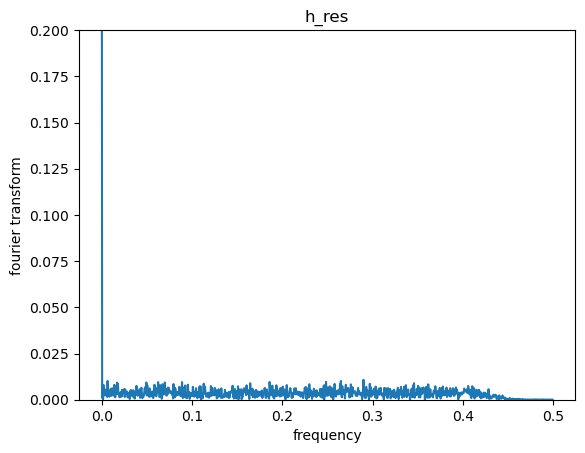

In [79]:
max_xlim = 0.04
fourier_transform = get_fourier_transform(get_random_sample(feature_label_df).loc[:, 'acc'])
fourier_transform
sns.lineplot(data = fourier_transform, x = 'frequency', y ='fourier transform')
#plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.title('h_res')
plt.show()

#### train the model

In [168]:
def get_fourier_vector(column_for_histogram, f_min, f_max):
    score_array = []
    measurement_ids = concat_feature_df.loc[:, 'measurement id'].unique()
    vectors = []
    for measurement_id in measurement_ids: 
        df = concat_feature_df[concat_feature_df.loc[:,'measurement id'] == measurement_id]
        fourier_df = get_fourier_transform(df.loc[:, column_for_histogram])
        filt = (fourier_df.loc[:, 'frequency'] >= f_min) & (fourier_df.loc[:, 'frequency'] <= f_max)
        filt_fourier_df = fourier_df[filt]
        vector = filt_fourier_df.loc[:, 'fourier transform']
        vectors += [vector]
    histogram_value_df = pd.DataFrame(vectors)
        
    X_train = histogram_value_df.values
    Y_train = label_meta_df.loc[:, 'label'].values
    # score = get_score(X_train, Y_train_encoded, num_bins)
    # score_array += [score]
    return X_train, Y_train

In [ ]:
X_train, Y_train= get_fourier_vector('l_res', 0, 0.4)
select_k_best_array = np.arange(5, X_train.shape[1], 5)
a = get_score(X_train, Y_train, True, Normalizer(), select_k_best_array)
a

Fitting 5 folds for each of 160 candidates, totalling 800 fits


#### plot the learning curve

In [ ]:
best_model = gridsearch.best_estimator_

# MAKE SURE to specify the groups here, too, when using a grouped validation strategy!

train_sizes, train_scores, val_scores = learning_curve(best_model,X1,y, 
                    groups=None, cv=cv, n_jobs=4, verbose=5)

# Plot learning curve
%matplotlib inline
ul2.plot_learning_curve(train_sizes, train_scores, val_scores)

### LDA on fourier transform

In [13]:
n_bins = 11
n_folds = 5
y = label_meta_df.loc[:, 'label'].values
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
x = feature_engineered_df.iloc[:, 1:].values
cv = KFold(n_splits=n_folds, shuffle = True, random_state = 42)

pipeline = Pipeline([
    #('discretizer', KBinsDiscretizer(n_bins, encode = 'ordinal', strategy = 'uniform')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest()),
    ('clf', LogisticRegression())
])
# param_grid = {
#     'feature_selection__selectkbest__k' : [660],
#     'classifier__clf__C' : [158.5],
# }

param_grid = {
    'feature_selection__k' : [2,4,9],
    'clf__C' : [0.1,1,10],
}

# define GridSearchCV object

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True, error_score='raise')

gridsearch.fit(x,encoded_y)

results = gridsearch.cv_results_
results_df = pd.DataFrame(results)
    #add the columns with more information about the number of pixels and the number of directions
    results_df.loc[:, 'scaler'] = str(scaler)
    results_df.loc[:, 'num_pixels'] = pix_per_cell
    results_df.loc[:, 'num_orientations'] = orientations
    display(results_df)
    df_array += [results_df]
    concatenated_df = pd.concat(df_array)
    concatenated_df.to_csv(filename, index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END clf__C=0.1, feature_selection__k=2;, score=(train=0.153, test=0.095) total time=   0.0s
[CV 2/5] END clf__C=0.1, feature_selection__k=2;, score=(train=0.152, test=0.114) total time=   0.0s
[CV 3/5] END clf__C=0.1, feature_selection__k=2;, score=(train=0.145, test=0.123) total time=   0.0s
[CV 4/5] END clf__C=0.1, feature_selection__k=2;, score=(train=0.150, test=0.123) total time=   0.0s
[CV 5/5] END clf__C=0.1, feature_selection__k=2;, score=(train=0.138, test=0.141) total time=   0.0s
[CV 1/5] END clf__C=0.1, feature_selection__k=4;, score=(train=0.174, test=0.127) total time=   0.0s
[CV 2/5] END clf__C=0.1, feature_selection__k=4;, score=(train=0.182, test=0.150) total time=   0.0s
[CV 3/5] END clf__C=0.1, feature_selection__k=4;, score=(train=0.167, test=0.132) total time=   0.0s
[CV 4/5] END clf__C=0.1, feature_selection__k=4;, score=(train=0.157, test=0.182) total time=   0.0s
[CV 5/5] END clf__C=0.1, featur

/apps/gent/RHEL8/cascadelake-ib/software/scikit-learn/1.2.1-gfbf-2022b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/apps/gent/RHEL8/cascadelake-ib/software/scikit-learn/1.2.1-gfbf-2022b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

[CV 2/5] END clf__C=10, feature_selection__k=9;, score=(train=0.210, test=0.159) total time=   0.0s
[CV 3/5] END clf__C=10, feature_selection__k=9;, score=(train=0.197, test=0.132) total time=   0.1s
[CV 4/5] END clf__C=10, feature_selection__k=9;, score=(train=0.195, test=0.164) total time=   0.0s
[CV 5/5] END clf__C=10, feature_selection__k=9;, score=(train=0.211, test=0.205) total time=   0.0s


/apps/gent/RHEL8/cascadelake-ib/software/scikit-learn/1.2.1-gfbf-2022b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/apps/gent/RHEL8/cascadelake-ib/software/scikit-learn/1.2.1-gfbf-2022b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

In [15]:
%matplotlib inline
result_df = pd.read_csv("favorite_20231031-175043.csv")
column_names = ['scaler', 'num_pixels', 'num_orientations','mean_fit_time', 'param_classifier__clf__C', 'param_feature_selection__selectkbest__k', 'mean_test_score', 'mean_train_score']
comp_result_df =  result_df[column_names]
# comp_result_df.loc[:, 'scaler'] =  comp_result_df.loc[:, 'scaler'].str[:-2]
plt.subplot(2,2,1)
sns.lineplot(data = comp_result_df,x = 'param_classifier__clf__C', y = 'mean_test_score', hue = 'scaler',palette='muted')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2,2,2)
sns.lineplot(data = comp_result_df,x = 'param_feature_selection__selectkbest__k', y = 'mean_test_score', hue = 'scaler',palette='muted')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2,2,3)
sns.lineplot(data = comp_result_df,x = 'param_classifier__clf__C', y = 'mean_train_score', hue = 'scaler',palette='muted')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2,2,4)
sns.lineplot(data = comp_result_df,x = 'param_feature_selection__selectkbest__k', y = 'mean_train_score', hue = 'scaler',palette='muted')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig = plt.gcf()
fig.set_size_inches(13, 6)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'favorite_20231031-175043.csv'

In [14]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_feature_selection__k,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008835,0.000535,0.000755,0.000032,0.1,2,"{'clf__C': 0.1, 'feature_selection__k': 2}",0.095455,0.113636,0.122727,...,0.119091,0.014771,9,0.153409,0.152273,0.145455,0.150000,0.137500,0.147727,0.005794
1,0.012017,0.000863,0.000741,0.000005,0.1,4,"{'clf__C': 0.1, 'feature_selection__k': 4}",0.127273,0.150000,0.131818,...,0.148182,0.019199,4,0.173864,0.181818,0.167045,0.156818,0.165909,0.169091,0.008363
2,0.018756,0.000887,0.000749,0.000008,0.1,9,"{'clf__C': 0.1, 'feature_selection__k': 9}",0.140909,0.140909,0.131818,...,0.146364,0.012332,5,0.205682,0.173864,0.171591,0.177273,0.193182,0.184318,0.013083
3,0.012421,0.000302,0.000738,0.000007,1,2,"{'clf__C': 1, 'feature_selection__k': 2}",0.109091,0.122727,0.136364,...,0.130909,0.015048,8,0.152273,0.159091,0.140909,0.151136,0.146591,0.150000,0.006056
4,0.019794,0.002064,0.000741,0.000010,1,4,"{'clf__C': 1, 'feature_selection__k': 4}",0.136364,0.159091,0.122727,...,0.152727,0.021818,2,0.175000,0.173864,0.165909,0.162500,0.177273,0.170909,0.005686
5,0.041541,0.003792,0.000754,0.000007,1,9,"{'clf__C': 1, 'feature_selection__k': 9}",0.145455,0.131818,0.118182,...,0.150000,0.025390,3,0.211364,0.190909,0.181818,0.185227,0.205682,0.195000,0.011557
6,0.020886,0.003359,0.000741,0.000006,10,2,"{'clf__C': 10, 'feature_selection__k': 2}",0.118182,0.136364,0.140909,...,0.135455,0.008814,7,0.139773,0.163636,0.153409,0.139773,0.138636,0.147045,0.009922
7,0.038238,0.017889,0.000759,0.000022,10,4,"{'clf__C': 10, 'feature_selection__k': 4}",0.145455,0.136364,0.122727,...,0.143636,0.013667,6,0.179545,0.187500,0.162500,0.177273,0.181818,0.177727,0.008338
8,0.048934,0.000528,0.000771,0.000038,10,9,"{'clf__C': 10, 'feature_selection__k': 9}",0.131818,0.159091,0.131818,...,0.158182,0.026722,1,0.215909,0.210227,0.196591,0.195455,0.211364,0.205909,0.008301


In [32]:
# create the fixed pipeline:

preprocessing = Pipeline([('normalizer',Normalizer())])  # Modify!
feature_selection = Pipeline([('selectkbest', SelectKBest())])  #  Feature selection. Do not modify!
classifier = Pipeline([('clf', LogisticRegression(max_iter=5000))])  # Classifier.

task1pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

param_grid = {
    'feature_selection__selectkbest__k' : [2,4,9],
    'classifier__clf__C' : [0.1,1,10],
}

# define GridSearchCV object

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True)


NameError: name 'Normalizer' is not defined

In [ ]:
y,poles = ul3.load_labels_and_poles(DATAPATH)

n_folds = 5 
cv = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=int(student_id))
groups = poles

print("Train set contains ",len(y)," samples")

In [ ]:
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(gr_df, label_meta_df.loc[:, 'label'], test_size=0.2, random_state=42)


In [ ]:
melt_gr_df = pd.melt(gr_df, id_vars = 'measurement', var_name = 'measurement_type', value_name= 'value')
sns.barplot(data = melt_gr_df, x = 'measurement', y = 'value', hue = 'measurement_type')

Is there a correlation between h_res and l_res?

In [ ]:
feature_label_df[['h_res', 'l_res']].corr()

There is a strong correlation between the two. 

In [ ]:
len(os.listdir(train_filepath))

### questions

- what is the resolution of h_res and l_res
- do h_res and l_res correlate? 
- try to understand where h_res and I_res come from: are they measured at the same point in the circuit
- try out the SVM with histogram features